In [5]:
!pip install osmnx keplergl geopandas shapely matplotlib pandas


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import osmnx as ox
import networkx as nx
from keplergl import KeplerGl
import plotly.express as px
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, MultiPoint, LineString
import matplotlib.pyplot as plt

In [208]:
from scipy.spatial import cKDTree

In [209]:
import numpy as np

In [214]:
from shapely import STRtree

# Data integration

In [7]:
# define the place name
place_name:str = "Graz, Austria"

# get the boundary polygon of Graz
gdf_graz = ox.geocode_to_gdf(place_name)

# change the crs to an Austrian metric CRS EPSG: 31256
gdf_graz = gdf_graz.to_crs(epsg=31256)

<Axes: >

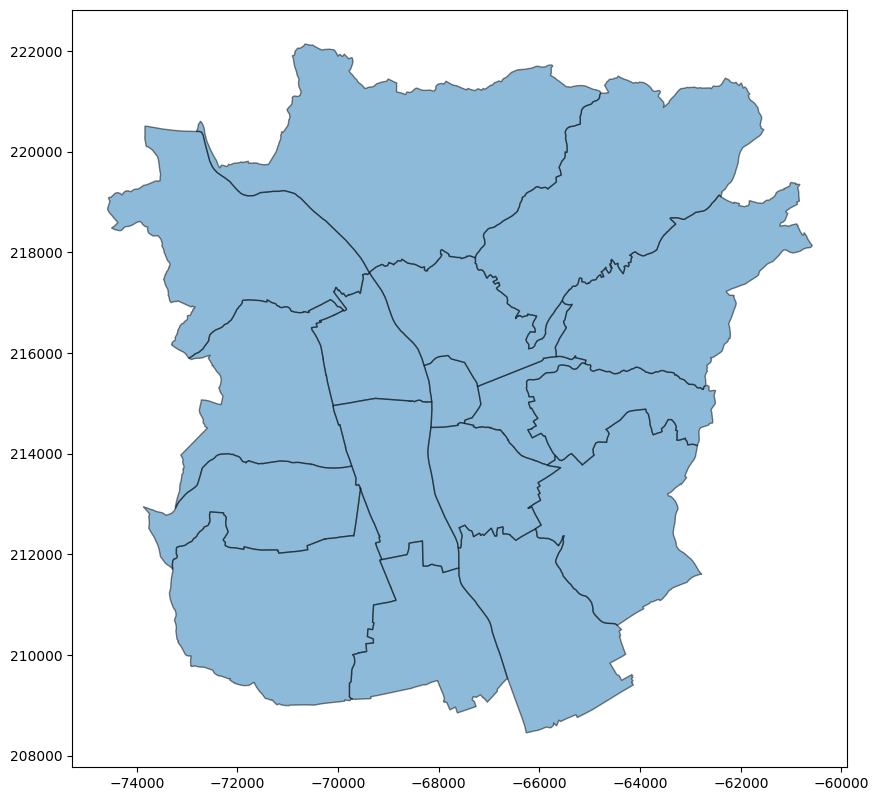

In [8]:
# Get districts of Graz
gdf_districts = ox.features_from_place(place_name, tags={'admin_level': '9'})

# Filter to only polygons and reproject
gdf_districts = gdf_districts[gdf_districts.geometry.type.isin(['Polygon', 'MultiPolygon'])]
gdf_districts = gdf_districts.to_crs(epsg=31256)

# Drop all columns except 'name' and 'geometry'
gdf_districts = gdf_districts[['name', 'geometry']]

# plot the districts
gdf_districts.plot(figsize=(10,10), alpha=0.5, edgecolor='k')

<Axes: >

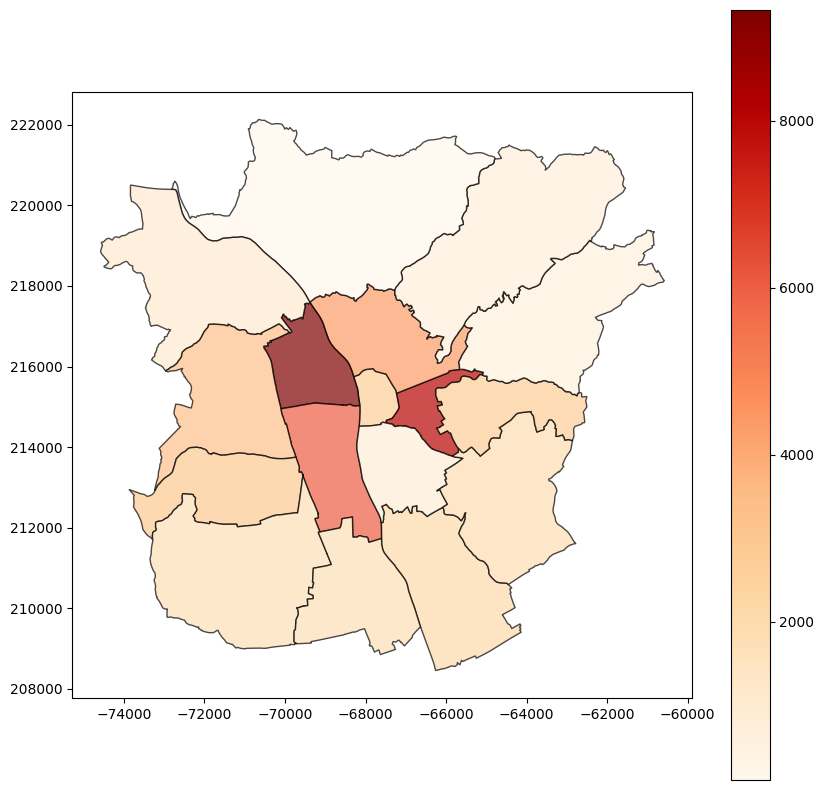

In [9]:
# Import population data and merge with districts
df_population = pd.read_csv("graz_bev.csv", header=0, sep=';')
gdf_bev_districts = gdf_districts.merge(df_population, left_on='name', right_on='Bezirk')
gdf_bev_districts = gdf_bev_districts.drop(columns=['Bezirk'])

#plot population density of districts
gdf_bev_districts.plot(column='Dichte', cmap='OrRd', legend=True, figsize=(10,10), alpha=0.7, edgecolor='k')

c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 251 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)


<Axes: >

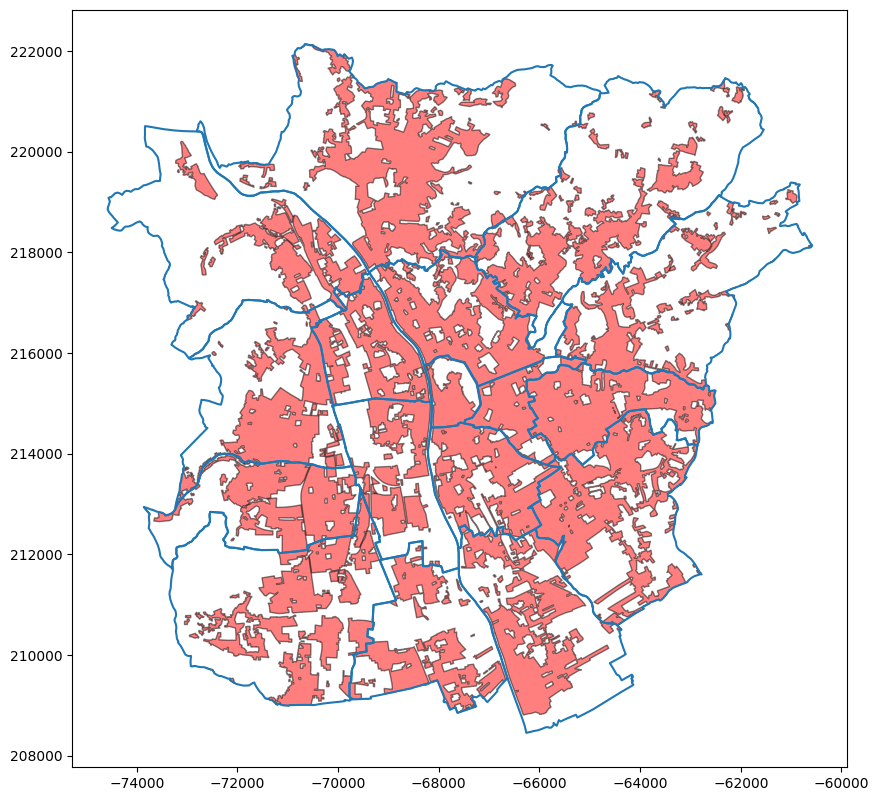

In [10]:
# get residential areas of Graz
gdf_residential = ox.features_from_place(place_name, tags={"landuse": "residential"})
gdf_residential = gdf_residential.to_crs(epsg=31256)
# dissolve all residential areas into one single geometry and cut to the boundary of Graz
gdf_residential = gdf_residential.dissolve()
gdf_residential = gpd.overlay(gdf_residential, gdf_graz, how='intersection')

# plot the residential areas and city districts
gdf_districts.boundary.plot(ax=gdf_residential.plot(figsize=(10,10), alpha=0.5, edgecolor='k', color='red'))

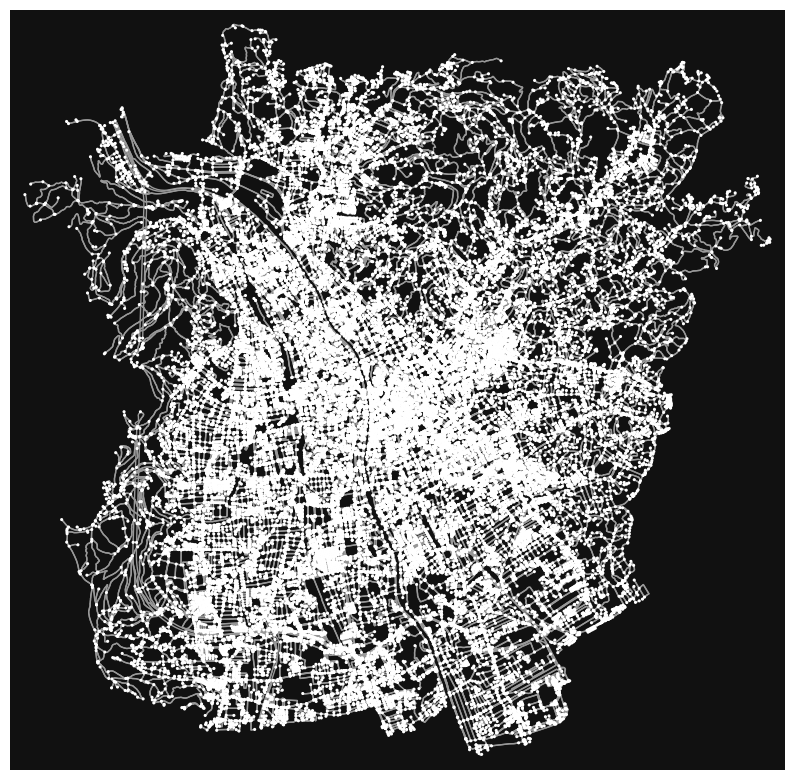

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [11]:
#if street network already exists, load it (to save time), otherwise download and save it
try:
    network_graz = ox.load_graphml("graz_street_network.graphml")
except:
    # get the street network for walking within the boundary of Graz
    network_graz = ox.graph_from_place(place_name, network_type="all")
    network_graz = ox.project_graph(network_graz, to_crs="epsg:31256")
    #save the graph
    ox.save_graphml(network_graz, filepath="graz_street_network.graphml")

# Plot the network using osmnx built-in function
ox.plot_graph(network_graz, node_size=5, figsize=(10,10))

<Axes: >

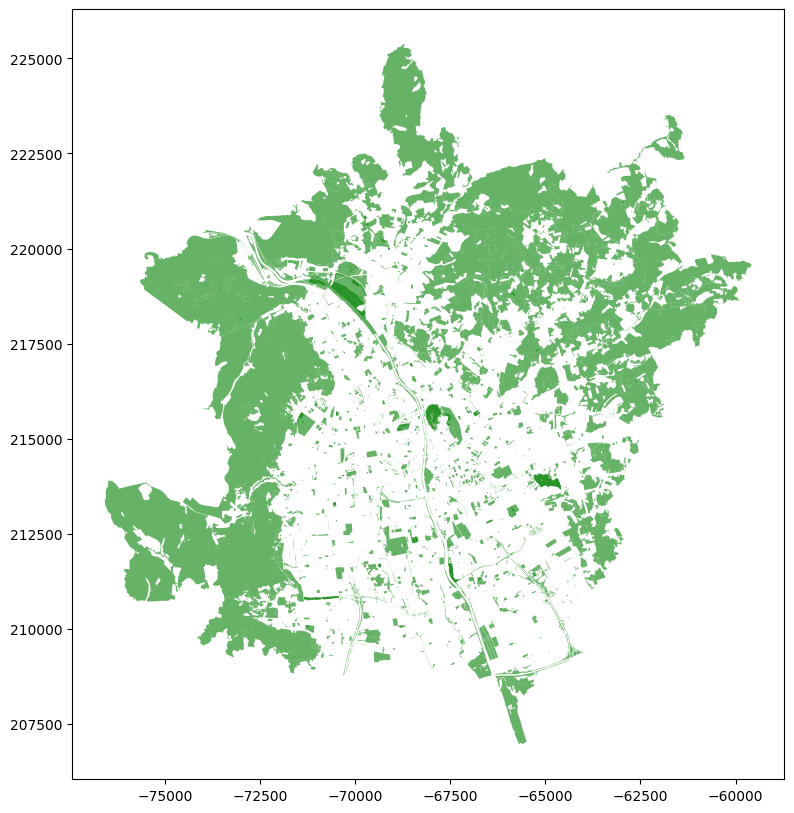

In [12]:
# Define tags for urban green spaces and parks
tags = {
    "leisure": ["park", "garden", "nature_reserve", "recreation_ground"],
    "landuse": ["forest", "grass", "meadow", "recreation_ground"]
}

tags = {
    "leisure": [
        "park",
        "garden",
        "nature_reserve",
        "recreation_ground",
        "pitch",          # often grassy sports fields
        "golf_course"
    ],
    "landuse": [
        "forest",
        "grass",
        "meadow",
        "recreation_ground",
        "allotments",
        "village_green",
        "cemetery"
    ],
    "natural": [
        "wood",
        "grassland",
        "scrub",
        "heath"
    ],
    "amenity": [
        "park",
        "playground"
        "graveyard"
    ]
}

# Download all green spaces in Graz & change the CRS
green_spaces = ox.features_from_place(place_name, tags=tags)
green_spaces = green_spaces[green_spaces.geometry.geom_type.isin(["Polygon", "MultiPolygon"])]
green_spaces = green_spaces.to_crs(epsg=31256)


# Quick visualization
green_spaces.plot(color='green', alpha=0.6, figsize=(10, 10))

In [13]:
map_green_spaces = KeplerGl(height=600)

map_green_spaces.add_data(data=green_spaces, name='green spaces')

map_green_spaces

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'green spaces': {'index': [('relation', 22203), ('relation', 1231619), ('relation', 1252339), (…

In [14]:
# Inspect data
green_spaces.info()
print(green_spaces.head())
print(green_spaces.columns)

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 4281 entries, ('relation', np.int64(22203)) to ('way', np.int64(1455321241))
Columns: 191 entries, geometry to managed
dtypes: geometry(1), object(190)
memory usage: 6.4+ MB
                                                           geometry amenity  \
element  id                                                                   
relation 22203    MULTIPOLYGON (((-65501.956 217899.938, -65503....     NaN   
         1231619  MULTIPOLYGON (((-67151.897 212730.969, -67113....     NaN   
         1252339  POLYGON ((-69251.105 212547.504, -69229.727 21...     NaN   
         1252342  POLYGON ((-69158.588 212189.28, -69169.839 212...     NaN   
         1263792  POLYGON ((-66492.198 214894.712, -66537.161 21...     NaN   

                 backrest                source level check_date operator  \
element  id                                                                 
relation 22203        NaN  GeoImage.at High-Res   NaN       

<Axes: >

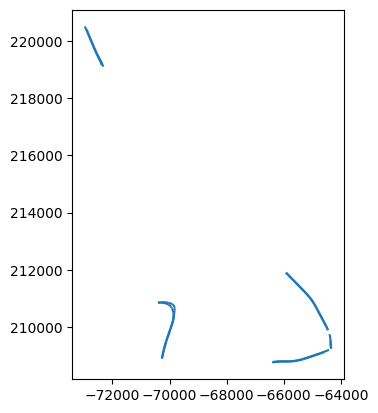

In [15]:
# Download Autobahnen and trunks in Graz from osmnx
highways = ox.features_from_place(
    place_name,
    tags={"highway": ["motorway", "trunk"]}
)
highways = highways.to_crs(epsg=31256)
highways = highways[highways['tunnel'] != 'yes']

#create buffer of 20 meters around highways
highway_buffer = highways.buffer(50)

highways.plot()

# Data management

In [16]:
# Clean data
# exclude green spaces that intersect with highway buffer
green_spaces = green_spaces[~green_spaces.geometry.intersects(highway_buffer.unary_union)]

#keep only relevant columns
green_spaces = green_spaces[['geometry', 'amenity', 'leisure', 'landuse', 'natural', 'sport', 'name','access']]
print(green_spaces.head())


                                                           geometry amenity  \
element  id                                                                   
relation 22203    MULTIPOLYGON (((-65501.956 217899.938, -65503....     NaN   
         1231619  MULTIPOLYGON (((-67151.897 212730.969, -67113....     NaN   
         1252339  POLYGON ((-69251.105 212547.504, -69229.727 21...     NaN   
         1252342  POLYGON ((-69158.588 212189.28, -69169.839 212...     NaN   
         1263792  POLYGON ((-66492.198 214894.712, -66537.161 21...     NaN   

                 leisure     landuse natural sport                      name  \
element  id                                                                    
relation 22203       NaN      forest     NaN   NaN                 Leechwald   
         1231619     NaN  allotments     NaN   NaN  Heimgartenverein Schönau   
         1252339     NaN    cemetery     NaN   NaN             Urnenfriedhof   
         1252342     NaN    cemetery     NaN  

C:\Users\tobia\AppData\Local\Temp\ipykernel_9032\340015225.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  green_spaces = green_spaces[~green_spaces.geometry.intersects(highway_buffer.unary_union)]


In [17]:
# Remove invalid green areas after visual inspection
green_spaces = green_spaces[~green_spaces['name'].isin(['Merkur Arena'])]
green_spaces = green_spaces[green_spaces['sport'].isna() | green_spaces['sport'].isin(['soccer', 'equestrian', 'golf', 'soccer; rugby', 'baseball', 'bmx', 'rugby', 'cricket', 'archery', 'baseball;cricket'])]


In [18]:

# Extract public-accessible green spaces (parks, urban forests, cemeteries etc.)
public_green = green_spaces[
    (green_spaces["leisure"].isin(["park", "garden", "recreation_ground"])) |
    (green_spaces["landuse"].isin(["forest", "recreation_ground", "cemetery"])) |
    (green_spaces["natural"].isin(["wood"])) |
    (green_spaces["amenity"].isin(["park", "playground", "graveyard"]))
]
# Drop private gardens without name
public_green = public_green[~((public_green["leisure"] == "garden") & (public_green["name"].isna()))]

#exclude public green spaces that are marked as 'no' or 'private' access
public_green = public_green[public_green['access'].isna() | public_green['access'].isin(['yes', 'permissive'])]

In [19]:
# Create categories for public green spaces: parks and gardens, urban forests, cemetery
# Create a new column 'category' based on conditions
def categorize_green_space(row):
    if row['leisure'] in ['park', 'garden', 'recreation_ground'] or row['landuse'] == 'recreation_ground' or row['amenity'] in ['park', 'playground']:
        return 'park_garden'
    elif row['landuse'] == 'forest' or row['natural'] == 'wood':
        return 'urban_forest'
    elif row['landuse'] == 'cemetery' or row['amenity'] == 'graveyard':
        return 'cemetery'
    else:
        return 'other' 
public_green['category'] = public_green.apply(categorize_green_space, axis=1)
print(public_green.head())

                                                           geometry amenity  \
element  id                                                                   
relation 22203    MULTIPOLYGON (((-65501.956 217899.938, -65503....     NaN   
         1252339  POLYGON ((-69251.105 212547.504, -69229.727 21...     NaN   
         1252342  POLYGON ((-69158.588 212189.28, -69169.839 212...     NaN   
         1263792  POLYGON ((-66492.198 214894.712, -66537.161 21...     NaN   
         1407987  POLYGON ((-68707.56 217977.097, -68643.402 217...     NaN   

                 leisure   landuse natural sport                    name  \
element  id                                                                
relation 22203       NaN    forest     NaN   NaN               Leechwald   
         1252339     NaN  cemetery     NaN   NaN           Urnenfriedhof   
         1252342     NaN  cemetery     NaN   NaN         Zentralfriedhof   
         1263792    park       NaN     NaN   NaN  Johannes-Zwerger

In [20]:
map_public = KeplerGl(height=600)

map_public.add_data(data=public_green, name='public green spaces')

map_public

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'public green spaces': {'index': [('relation', 22203), ('relation', 1252339), ('relation', 1252…

In [21]:
# Exclude green spaces under 2000 m2
public_green_clean = public_green[public_green.geometry.area >= 10000]

In [22]:
map_public_c = KeplerGl(height=600)

map_public_c.add_data(data=public_green_clean, name='public green spaces')

map_public_c

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'public green spaces': {'index': [('relation', 22203), ('relation', 1252339), ('relation', 1252…

In [23]:
# Dissolve green areas by category
public_green_clean = public_green.dissolve(by='category', as_index=False)

In [24]:
public_green_all = public_green_clean.dissolve(as_index=False)
edges = ox.graph_to_gdfs(network_graz, nodes=False, edges=True)

Found 3004 access points


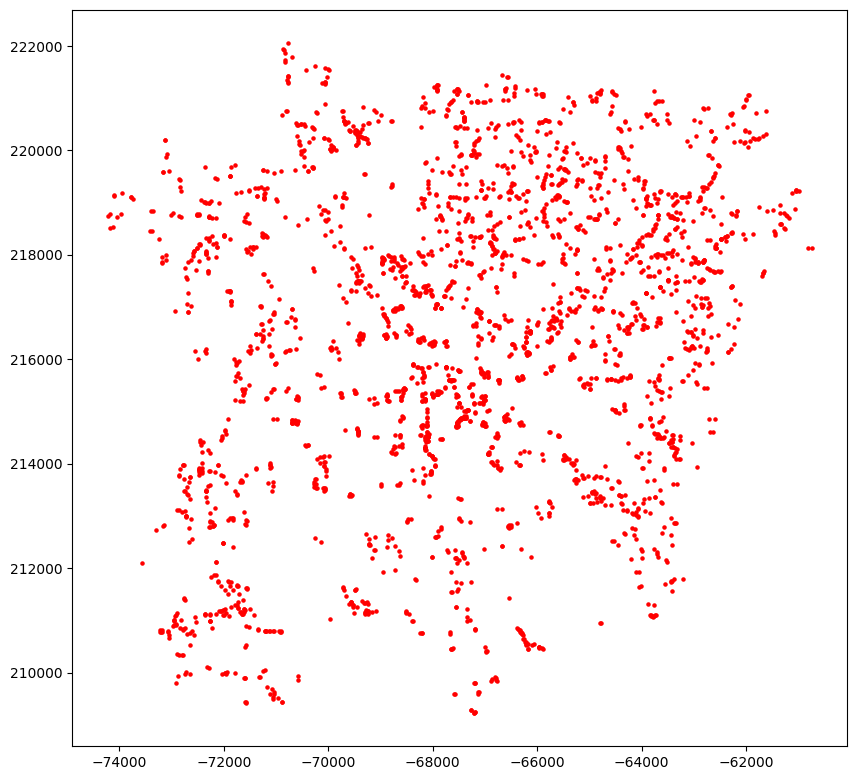

In [25]:
# Extract boundaries of parks as LineStrings
park_boundaries = public_green_all.boundary.iloc[0]  # Get the actual geometry

# Create a list to store access points
access_points_list = []

# Iterate through each edge and find intersections with park boundaries
for idx, edge in edges.iterrows():
    intersection = edge.geometry.intersection(park_boundaries)
    
    if not intersection.is_empty:
        if intersection.geom_type == 'Point':
            access_points_list.append(intersection)
        elif intersection.geom_type == 'MultiPoint':
            access_points_list.extend(list(intersection.geoms))
        elif intersection.geom_type == 'LineString':
            access_points_list.extend([Point(intersection.coords[0]), Point(intersection.coords[-1])
    ])

# Create GeoDataFrame of access points
access_points = gpd.GeoDataFrame(
    geometry=access_points_list,
    crs=edges.crs
)

# Remove duplicates
access_points = access_points.drop_duplicates(subset=['geometry'])

# Plot
access_points.plot(figsize=(10, 10), color='red', markersize=5)
print(f"Found {len(access_points)} access points")

In [26]:
map_access = KeplerGl(height=600)

map_access.add_data(data=access_points, name='access points')
map_access.add_data(data=edges, name='street network')
map_access.add_data(data=public_green_all, name='public green spaces')

map_access

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'access points': {'index': [0, 1, 2, 3, 4, 5, 6, 8, 13, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25,…

# Method 1: Euclidean Distance

In [27]:
# Create distance buffers of 100, 200, 300, and more metres around the park access points
DISTS:list[int] = [100, 200, 300]  # in meters
graz_boundary = gdf_graz.unary_union  # Get the city boundary as a single polygon

for d in DISTS:
    # Create buffers and clip to city boundary
    access_points[f'buffer_{d}m'] = access_points.geometry.buffer(d).intersection(graz_boundary)
#create buffer for distances over 300m and convert graz boundry to polygon
graz_polygon = gpd.GeoDataFrame(geometry=[graz_boundary], crs=access_points.crs)
access_points['buffer_over_300m'] = graz_polygon.difference(access_points['buffer_300m'].unary_union)

C:\Users\tobia\AppData\Local\Temp\ipykernel_9032\126994333.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  graz_boundary = gdf_graz.unary_union  # Get the city boundary as a single polygon
C:\Users\tobia\AppData\Local\Temp\ipykernel_9032\126994333.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  access_points['buffer_over_300m'] = graz_polygon.difference(access_points['buffer_300m'].unary_union)


In [28]:
# Dissolve buffers
eucl_buffers = {}
#set previous buffer union to empty geometry
previous_union = gpd.GeoSeries([gpd.GeoSeries([]).unary_union], crs=access_points.crs).unary_union
#loop thorugh distances, dissolve and subtract previous buffers
for d in DISTS:
    eucl_buffers[d] = gpd.GeoDataFrame(geometry=access_points[f'buffer_{d}m']).dissolve()
    #subtract previous buffers to create rings
    eucl_buffers[d]['geometry'] = eucl_buffers[d].geometry.difference(previous_union)
    #update previous union
    previous_union = eucl_buffers[d].geometry.unary_union
# Dissolve buffer over 300m
eucl_buffers['over_300m'] = gpd.GeoDataFrame(geometry=access_points['buffer_over_300m'])

C:\Users\tobia\AppData\Local\Temp\ipykernel_9032\3462028111.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  previous_union = gpd.GeoSeries([gpd.GeoSeries([]).unary_union], crs=access_points.crs).unary_union
C:\Users\tobia\AppData\Local\Temp\ipykernel_9032\3462028111.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  previous_union = gpd.GeoSeries([gpd.GeoSeries([]).unary_union], crs=access_points.crs).unary_union
C:\Users\tobia\AppData\Local\Temp\ipykernel_9032\3462028111.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  previous_union = eucl_buffers[d].geometry.unary_union
C:\Users\tobia\AppData\Local\Temp\ipykernel_9032\3462028111.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  previous_union = eucl_buffers[d].geometry.unary_union
C:\Users\tobia\A

In [29]:
# Intersect buffers with residential areas
eucl_dist_res = {}
for key, value in eucl_buffers.items():
    eucl_dist_res[key] = gpd.overlay(value, gdf_residential, how='intersection')

# Calculate area and percentage of green residential areas by subtractig outer buffer from residential areas
green_areas_eucl = gpd.overlay(gdf_residential, eucl_buffers['over_300m'], how='difference')
percent_green_eucl = (green_areas_eucl.geometry.area.sum() / gdf_residential.geometry.area.sum()) * 100
print(f"Percentage of residential areas within 300m of green space: {percent_green_eucl:.2f}%")


# Calculate deficient area (not within 300 m of green space) in total 
deficient_area_eucl = gpd.overlay(gdf_residential, eucl_buffers['over_300m'], how='intersection')
percent_deficient_eucl = (deficient_area_eucl.geometry.area.sum() / gdf_residential.geometry.area.sum()) * 100
print(f"Percentage of residential areas not within 300m of green space: {percent_deficient_eucl:.2f}%")


Percentage of residential areas within 300m of green space: 74.46%
Percentage of residential areas not within 300m of green space: 25.54%


c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 13 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 6 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  result = _collection_extract(result, geom_type, keep_geom_type_warning)
c:\Users\tobia\OneDrive\Desktop\Uni\Semester_3\GIS2\Python\venv-gst200b\Lib\site-packages\geopandas\tools\overlay.py:358: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_typ

District: Innere Stadt, Percentage of residential areas not within 300m of green space: 0.06%
District: Liebenau, Percentage of residential areas not within 300m of green space: 63.75%
District: Sankt Leonhard, Percentage of residential areas not within 300m of green space: 0.52%
District: Geidorf, Percentage of residential areas not within 300m of green space: 1.49%
District: Lend, Percentage of residential areas not within 300m of green space: 13.66%
District: Gries, Percentage of residential areas not within 300m of green space: 12.91%
District: Jakomini, Percentage of residential areas not within 300m of green space: 18.86%
District: Sankt Peter, Percentage of residential areas not within 300m of green space: 25.78%
District: Waltendorf, Percentage of residential areas not within 300m of green space: 31.08%
District: Ries, Percentage of residential areas not within 300m of green space: 1.24%
District: Mariatrost, Percentage of residential areas not within 300m of green space: 8.72%

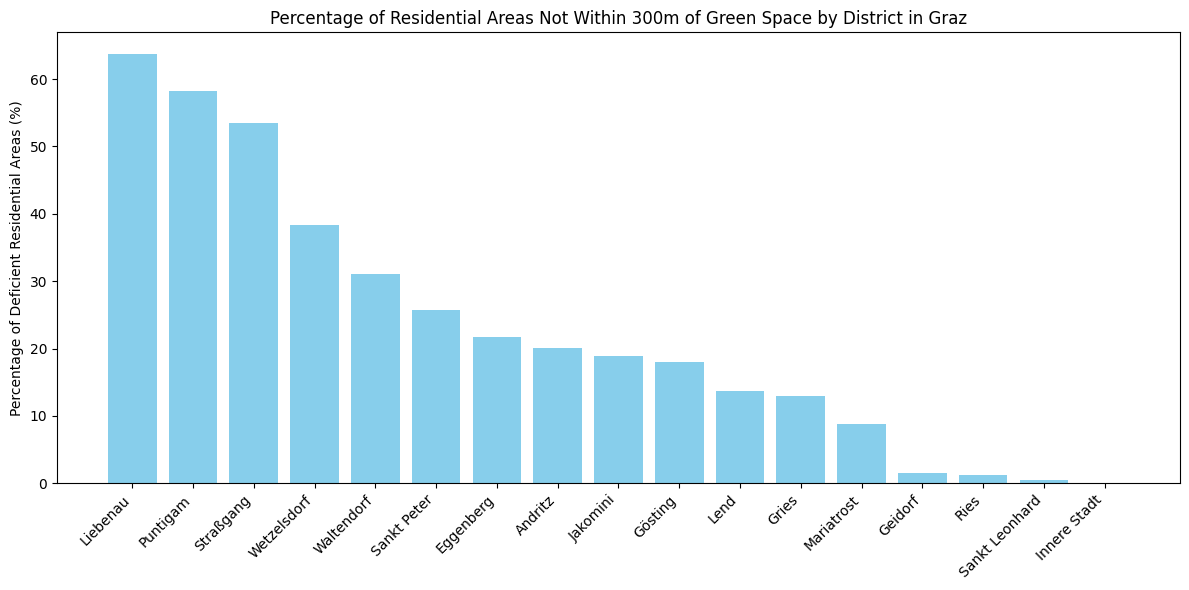

In [30]:
# Calculate deficient areas for each district
deficient_areas_districts = {}
for district in gdf_districts['name']:
    district_geom = gdf_districts[gdf_districts['name'] == district].geometry.union_all()
    residential_in_district = gpd.overlay(gdf_residential, gpd.GeoDataFrame(geometry=[district_geom], crs=gdf_residential.crs), how='intersection')
    deficient_area_district = gpd.overlay(residential_in_district, eucl_buffers['over_300m'], how='intersection')
    percent_deficient_district = (deficient_area_district.geometry.area.sum() / residential_in_district.geometry.area.sum()) * 100
    deficient_areas_districts[district] = percent_deficient_district

#print results and create bar chart
for district, percent_deficient_district in deficient_areas_districts.items():
    print(f"District: {district}, Percentage of residential areas not within 300m of green space: {percent_deficient_district:.2f}%")

# Create bar chart soreted by percentage
deficient_areas_districts_sorted = dict(sorted(deficient_areas_districts.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(12, 6))
plt.bar(deficient_areas_districts_sorted.keys(), deficient_areas_districts_sorted.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percentage of Deficient Residential Areas (%)')
plt.title('Percentage of Residential Areas Not Within 300m of Green Space by District in Graz')
plt.tight_layout()
plt.show()

In [31]:
# How much of residential areas are within each buffer?
buffer_res_eucl = {}
buffer_res_eucl_area = {}
for key, value in eucl_buffers.items():
    buffer_res_eucl[key] = gpd.overlay(value, gdf_residential, how='intersection')
    buffer_res_eucl_area[key] = buffer_res_eucl[key].geometry.area.sum()/gdf_residential.geometry.area.sum() * 100
    # Print percentual areas
    print(f"Percentage of residential areas within {key}m of green space: {buffer_res_eucl_area[key]:.2f}%")
    

Percentage of residential areas within 100m of green space: 22.83%
Percentage of residential areas within 200m of green space: 31.30%
Percentage of residential areas within 300m of green space: 43.17%
Percentage of residential areas within over_300mm of green space: 25.54%


In [32]:
# Population within each distance?
## interect districts with buffers and sum population
population_within_buffers = {}
for key, value in eucl_buffers.items():
    intersected = gpd.overlay(gdf_bev_districts, value, how='intersection')
    intersected['area'] = intersected.geometry.area
    intersected['population_within_buffer'] = (intersected['area'] / gdf_bev_districts.set_index('name').loc[intersected['name'], 'geometry'].area.values) * gdf_bev_districts.set_index('name').loc[intersected['name'], 'EW'].values
    total_population = intersected['population_within_buffer'].sum()
    population_within_buffers[key] = total_population
    print(f"Population within {key}m of green space: {total_population:.0f}, ({(total_population / gdf_bev_districts['EW'].sum()) * 100:.2f}%)")


Population within 100m of green space: 66649, (25.49%)
Population within 200m of green space: 79153, (30.27%)
Population within 300m of green space: 119788, (45.81%)
Population within over_300mm of green space: 62524, (23.91%)


# Method 2: Network Analysis

In [55]:
access_points.iloc[0]['geometry'].x

-65251.250840985536

In [216]:
print("Building spatial index...")

# Create array of edge geometries
edge_geoms = edges.geometry.values

# Build STRtree spatial index
tree = STRtree(edge_geoms)

print(f"Processing {len(access_points)} access points...")
access_point_edges = []

for idx, access_point in access_points.iterrows():
    point = access_point.geometry
    
    # Query nearest geometries using the spatial index
    # Use query with a small buffer to get candidates
    buffer_candidates = tree.query(point.buffer(100))  # 100m buffer to get candidates
    
    # If no candidates found with 100m, expand search
    if len(buffer_candidates) == 0:
        buffer_candidates = tree.query(point.buffer(500))
    
    # Find the truly closest edge among candidates
    min_distance = float('inf')
    best_edge_idx = None
    best_projection = None
    
    for candidate_idx in buffer_candidates:
        edge_geom = edge_geoms[candidate_idx]
        distance = point.distance(edge_geom)
        
        if distance < min_distance:
            min_distance = distance
            best_edge_idx = candidate_idx
            best_projection = edge_geom.interpolate(edge_geom.project(point))
    
    # If still no match found, do brute force search (shouldn't happen often)
    if best_edge_idx is None:
        distances = [point.distance(geom) for geom in edge_geoms]
        best_edge_idx = np.argmin(distances)
        min_distance = distances[best_edge_idx]
        best_projection = edge_geoms[best_edge_idx].interpolate(
            edge_geoms[best_edge_idx].project(point)
        )
    
    # Extract u and v from the MultiIndex
    edge_index = edges.index[best_edge_idx]
    u_node = edge_index[0]
    v_node = edge_index[1]
    
    # Get edge properties
    edge_geom = edge_geoms[best_edge_idx]
    edge_length = edge_geom.length
    dist_from_u = edge_geom.project(best_projection)
    
    access_point_edges.append({
        'access_point_id': idx,
        'edge_idx': best_edge_idx,
        'projected_point': best_projection,
        'distance_to_edge': min_distance,
        'u': u_node,
        'v': v_node,
        'total_edge_length': edge_length,
        'distance_from_u': dist_from_u,
    })
    
    # Progress indicator
    if (len(access_point_edges)) % 100 == 0:
        print(f"Processed {len(access_point_edges)}/{len(access_points)} access points")

# Create the DataFrame
access_edges_df = pd.DataFrame(access_point_edges)

print(f"\nProcessed {len(access_edges_df)} access points")
print(f"Max distance to nearest edge: {access_edges_df['distance_to_edge'].max():.2f}m")
print(f"Mean distance to nearest edge: {access_edges_df['distance_to_edge'].mean():.2f}m")

Building spatial index...
Processing 3014 access points...
Processed 100/3014 access points
Processed 200/3014 access points
Processed 300/3014 access points
Processed 400/3014 access points
Processed 500/3014 access points
Processed 600/3014 access points
Processed 700/3014 access points
Processed 800/3014 access points
Processed 900/3014 access points
Processed 1000/3014 access points
Processed 1100/3014 access points
Processed 1200/3014 access points
Processed 1300/3014 access points
Processed 1400/3014 access points
Processed 1500/3014 access points
Processed 1600/3014 access points
Processed 1700/3014 access points
Processed 1800/3014 access points
Processed 1900/3014 access points
Processed 2000/3014 access points
Processed 2100/3014 access points
Processed 2200/3014 access points
Processed 2300/3014 access points
Processed 2400/3014 access points
Processed 2500/3014 access points
Processed 2600/3014 access points
Processed 2700/3014 access points
Processed 2800/3014 access point

In [218]:

print(f"Original graph: {network_graz.number_of_nodes()} nodes, {network_graz.number_of_edges()} edges")

# Step 2: Add virtual nodes to the graph
G_modified = network_graz.copy()

successful_splits = 0
skipped_edges = 0

for idx, row in access_edges_df.iterrows():
    virtual_node_id = f"access_{row['access_point_id']}"
    edge_u = row['u']
    edge_v = row['v']
    
    # Check if edge exists in graph
    if not G_modified.has_edge(edge_u, edge_v):
        print(f"Warning: Edge {edge_u}->{edge_v} not in graph, skipping")
        skipped_edges += 1
        continue
    
    # Get original edge data
    edge_data = G_modified[edge_u][edge_v]
    
    if isinstance(edge_data, dict):
        # MultiGraph - get the first edge (key 0)
        if 0 in edge_data:
            original_edge = edge_data[0].copy()
        else:
            # Take the first available key
            first_key = list(edge_data.keys())[0]
            original_edge = edge_data[first_key].copy()
    else:
        original_edge = edge_data.copy()
    
    # Get distances
    total_length = original_edge.get('length', row['total_edge_length'])
    dist_from_u = row['distance_from_u']
    dist_from_v = total_length - dist_from_u
    
    # Skip if virtual node would be too close to existing nodes (< 1m)
    if dist_from_u < 1.0 or dist_from_v < 1.0:
        skipped_edges += 1
        continue
    
    # Add virtual node
    G_modified.add_node(
        virtual_node_id,
        x=row['projected_point'].x,
        y=row['projected_point'].y
    )
    
    # Remove original edge (all keys if MultiGraph)
    G_modified.remove_edge(edge_u, edge_v)
    
    # Filter edge attributes to only include string keys
    edge_attrs = {
        k: v for k, v in original_edge.items() 
        if isinstance(k, str) and k != 'length'
    }
    
    # Add two new edges (split at access point)
    # Edge from u to virtual node
    G_modified.add_edge(
        edge_u, 
        virtual_node_id,
        length=dist_from_u,
        **edge_attrs
    )
    
    # Edge from virtual node to v
    G_modified.add_edge(
        virtual_node_id, 
        edge_v,
        length=dist_from_v,
        **edge_attrs
    )
    
    successful_splits += 1
    
    # Progress indicator
    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1}/{len(access_edges_df)} edges")

print(f"\nModified graph: {G_modified.number_of_nodes()} nodes, {G_modified.number_of_edges()} edges")
print(f"Successfully split {successful_splits} edges")
print(f"Skipped {skipped_edges} edges")
print(f"Added {successful_splits} virtual access point nodes")

Original graph: 58259 nodes, 153276 edges
Processed 100/3014 edges
Processed 200/3014 edges
Processed 300/3014 edges
Processed 400/3014 edges
Processed 500/3014 edges
Processed 600/3014 edges
Processed 700/3014 edges
Processed 800/3014 edges
Processed 900/3014 edges
Processed 1000/3014 edges
Processed 1100/3014 edges
Processed 1200/3014 edges
Processed 1300/3014 edges
Processed 1500/3014 edges
Processed 1600/3014 edges
Processed 1700/3014 edges
Processed 1800/3014 edges
Processed 1900/3014 edges
Processed 2000/3014 edges
Processed 2100/3014 edges
Processed 2200/3014 edges
Processed 2300/3014 edges
Processed 2400/3014 edges
Processed 2500/3014 edges
Processed 2600/3014 edges
Processed 2700/3014 edges
Processed 2800/3014 edges
Processed 2900/3014 edges

Modified graph: 60552 nodes, 155569 edges
Successfully split 2293 edges
Skipped 721 edges
Added 2293 virtual access point nodes


In [220]:
# visualize modified network and access points with kepler

nodes_mod = ox.graph_to_gdfs(G_modified, nodes=True, edges=False)
edges_mod = ox.graph_to_gdfs(G_modified, nodes=False, edges=True)

map3 = KeplerGl(height=600)

map3.add_data(data=access_points, name='access points')
map3.add_data(data=edges_mod, name='edges')
map3.add_data(data=nodes_mod, name='nodes')

map3

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\vitad\studium\GST_S3\GAT2\venv-gst200b311\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
c:\Users\vitad\studium\GST_S3\GAT2\venv-gst200b311\Lib\site-packages\jupyter_client\session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'access points': {'index': [0, 1, 2, 3, 4, 5, 6, 8, 13, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25,…

In [232]:
# Calculate nearest node in the network for each access point
access_nodes = ox.distance.nearest_nodes(G_modified, access_points.geometry.x, access_points.geometry.y)
print(access_nodes)
access_nodes = list(access_nodes)

['access_0' 841577266 'access_2' ... 'access_6245' 13260177763
 'access_6247']


In [241]:
# access_nodes: iterable of your origins
# DISTS: iterable of max distances

results = {}  # e.g. {(max_dist, node): dist}
distance = max(DISTS)
lengths = nx.multi_source_dijkstra_path_length(
    G_modified,
    sources=access_nodes,
    cutoff=distance,
    weight='length',  # your edge attribute
)
# lengths: {node: distance_to_nearest_access_node}
for node, dist in lengths.items():
    results[node] = dist
    print(results[node])



0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [267]:
nodes_mod.drop(columns=['access_dist'])

,y,x,street_count,highway,railway,ref,junction,geometry
osmid,,,,,,,,
20824331,210217.791815,-64616.248094,3.0,NaN,NaN,NaN,NaN,POINT (-64616.248 210217.792)
35126490,210851.318915,-64962.538698,3.0,motorway_junction,NaN,NaN,NaN,POINT (-64962.539 210851.319)
20824406,211576.094290,-64117.117821,3.0,NaN,NaN,NaN,NaN,POINT (-64117.118 211576.094)
1450590079,211640.578891,-64114.823531,5.0,NaN,NaN,NaN,NaN,POINT (-64114.824 211640.579)
35127847,211534.195660,-64133.160771,5.0,traffic_signals,NaN,NaN,NaN,POINT (-64133.161 211534.196)
...,...,...,...,...,...,...,...,...
access_6209,220446.574368,-68232.949833,NaN,NaN,NaN,NaN,NaN,POINT (-68232.95 220446.574)
access_6230,221549.261283,-69992.988002,NaN,NaN,NaN,NaN,NaN,POINT (-69992.988 221549.261)
access_6231,221562.266134,-70009.755893,NaN,NaN,NaN,NaN,NaN,POINT (-70009.756 221562.266)


In [269]:
dist_df = pd.DataFrame(list(results.items()), 
                      columns=['node_id', 'access_dist'])
dist_df.set_index('node_id', inplace=True)

nodes_distance = pd.merge(nodes_mod, dist_df, 
                     left_index=True, right_index=True, how='left')
#nodes_dist['access_dist'] = nodes_dist['access_dist'].fillna(np.inf)

nodes_distance


,y,x,street_count,highway,railway,ref,junction,geometry,access_dist_x,access_dist_y
osmid,,,,,,,,,,
20824331,210217.791815,-64616.248094,3.0,NaN,NaN,NaN,NaN,POINT (-64616.248 210217.792),inf,NaN
35126490,210851.318915,-64962.538698,3.0,motorway_junction,NaN,NaN,NaN,POINT (-64962.539 210851.319),inf,NaN
20824406,211576.094290,-64117.117821,3.0,NaN,NaN,NaN,NaN,POINT (-64117.118 211576.094),inf,157.816439
1450590079,211640.578891,-64114.823531,5.0,NaN,NaN,NaN,NaN,POINT (-64114.824 211640.579),inf,92.969645
35127847,211534.195660,-64133.160771,5.0,traffic_signals,NaN,NaN,NaN,POINT (-64133.161 211534.196),inf,203.031428
...,...,...,...,...,...,...,...,...,...,...
access_6209,220446.574368,-68232.949833,NaN,NaN,NaN,NaN,NaN,POINT (-68232.95 220446.574),inf,0.000000
access_6230,221549.261283,-69992.988002,NaN,NaN,NaN,NaN,NaN,POINT (-69992.988 221549.261),inf,0.000000
access_6231,221562.266134,-70009.755893,NaN,NaN,NaN,NaN,NaN,POINT (-70009.756 221562.266),inf,0.000000


Index([     20824331,      35126490,      20824406,    1450590079,
            35127847,      20824610,      21015416,      20825435,
          1447016181,      20824622,
       ...
       'access_6155', 'access_6161', 'access_6167', 'access_6196',
       'access_6200', 'access_6209', 'access_6230', 'access_6231',
       'access_6245', 'access_6247'],
      dtype='object', name='osmid', length=60552)

In [ ]:
# One to all routing from all nearest nodes of access points with a maximum of dist
route_buffers = {}
previous_union = gpd.GeoSeries([gpd.GeoSeries([]).unary_union], crs=nodes_route_dist.crs).unary_union
for d in DISTS:
    # For each access point node, calculate shortest path lengths to all other nodes within distance d
    for access_node in nearest_nodes_access:
        lengths = nx.single_source_dijkstra_path_length(network_graz, access_node, cutoff=d, weight='length')
        # Update minimum distances in nodes_route_dist
        for node, length in lengths.items():
            if length < nodes_route_dist.at[node, 'min_dist']:
                nodes_route_dist.at[node, 'min_dist'] = length
    # Create buffer around nodes with min_dist less than or equal to d
    reachable_nodes = nodes_route_dist[nodes_route_dist['min_dist'] <= d]
    reachable_buffer = reachable_nodes.buffer(0)  # Create zero-width buffer to convert points to polygons
    # Dissolve buffers to create a single geometry
    reachable_buffer_dissolved = gpd.GeoDataFrame(geometry=[reachable_buffer.unary_union], crs=nodes_route_dist.crs)
    # Clip to city boundary
    reachable_buffer_clipped = gpd.overlay(reachable_buffer_dissolved, gdf_graz, how='intersection')
    #subtract previous buffers to create rings
    reachable_buffer_clipped['geometry'] = reachable_buffer_clipped.geometry.difference(previous_union)
    #update previous union
    previous_union = reachable_buffer_clipped.geometry.unary_union
    # Store the buffer
    route_buffers[d] = reachable_buffer_clipped

#plot buffers with kepler
map_route_buffers = KeplerGl(height=600)
for d in DISTS:
    map_route_buffers.add_data(data=route_buffers[d], name=f'route_buffer_{d}m')
map_route_buffers


In [ ]:
# Dissolve buffers

In [ ]:
# Create distance buffers of 50, 150 and 300 metres walking distance around bus stations

Indicators:
total number of public parks
total area of public parks and gardens within a neighbourhood or within walking distance buffers
percentage of land covered by green spaces from the total urban area
total surface area of public parks within a neighbourhood relative to population.

# Results

In [ ]:
# Visualize green spaces in the city

In [ ]:
# Calculate the density of parks using Kernel density function

In [ ]:
# Relate data of green spaces to total area of city / districts


In [ ]:
# Population density map

In [ ]:
# Map of accessbility to green areas by foot (buffers, green areas and residential areas)

map_euclid = KeplerGl(height=600)

for d in DISTS:
    map_euclid.add_data(data=eucl_buffers[d], name=f'Buffer {d}m')
map_euclid.add_data(data=eucl_buffers['over_300m'], name='Buffer over 300m')
map_euclid

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Buffer 100m': {'index': [0], 'columns': ['geometry'], 'data': [['MULTIPOLYGON (((15.3729696072…

In [ ]:
# Map of population density and deficient areas

In [ ]:
# Choropleth map of deficient area percentage within each district